In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns
%matplotlib inline

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


- The German Statistical agency makes available daily all-cause mortality data here: https://www.destatis.de/DE/Themen/Gesellschaft-Umwelt/Bevoelkerung/Sterbefaelle-Lebenserwartung/sterbefallzahlen.html $\to$ "Download Sonderauswertung Sterbefälle – Fallzahlen nach Tagen, Monaten, Altersgruppen und Bundesländern für Deutschland 2016 bis 2020". **We have not yet found daily data for 2015 and will update the analysis as soon as we do.**

- Official data on Covid-19 mortality come from the Robert-Koch Institute: https://npgeo-corona-npgeo-de.hub.arcgis.com/ $\to$ Frei zugängliche Daten nach Kategorien $\to$ Robert Koch-Institut $\to$ RKI COVID19 $\to$ Data
 
**IMPORTANT** The German all-cause mortality numbers for 2016-2018 are the official, vetted, final numbers. For 2019 and especially 2020, numbers are provisional estimates. In particluar, they write: 

"*Für die Jahre 2019 und 2020 werden erste vorläufige Daten dargestellt – hierbei handelt es sich um eine reine Fallzahlauszählung der eingegangenen Sterbefallmeldungen aus den Standesämtern ohne die übliche Plausibilisierung und Vollständigkeitskontrolle der Daten. Durch gesetzliche Regelungen zur Meldung von Sterbefällen beim Standesamt und Unterschiede im Meldeverhalten der Standesämter an die amtliche Statistik sind aktuelle Aussagen zur Zahl der Sterbefälle mit einem Verzug von etwa vier Wochen möglich. Durch die verzögerten Meldungen können sich die ersten Ergebnisse für das Jahr 2020 noch leicht erhöhen.*" 

This means:

"*For the years 2019 and 2020, the first preliminary data are presented - this is a pure case count of the death notifications received from the registry offices without the usual plausibility checks and completeness checks of the data. Due to legal regulations concerning the reporting of deaths at the registry office and differences in the reporting behaviour of the registry offices to the official statistics, up-to-date statements on the number of deaths are possible with a delay of about four weeks. Due to the delays in reporting, the first results for 2020 may still be slightly higher.*"






# 1) Parsing the all-cause mortality data

In [2]:
def dump_excel_to_df(year):
    
    df = pd.read_excel('./total_deaths/sonderauswertung_sterbefaelle_2016_2020.xlsx',
                       sheet_name='D_{}_Tage'.format(year),skiprows=8).T
    df = pd.DataFrame(df.iloc[:,1])
    df = pd.DataFrame(df.iloc[1:])
    df.reset_index(inplace=True)
    df.columns = ['date', '{}'.format(year)]
    df = df[df.date!='Insgesamt']
    df['month'] = df.date.astype('str').str[5:7]
    df['day'] = df.date.astype('str').str[8:10]
    
    df = df[['month', 'day', '{}'.format(year)]].reset_index(drop=True).copy(deep=True)
    return df

In [3]:
for yr in range(2016, 2021):
    
    dfy = dump_excel_to_df(yr)
    if yr == 2016:
        df = dfy.copy(deep=True)
    else:
        df = pd.merge(df, dfy, on=['month', 'day'], how='outer').reset_index(drop=True).copy(deep=True)

First official Covid-death in Germany: 2020-03-04 $\to$ drop all days before March 3rd.

In [4]:
df['date'] = '2020-' + df.month + '-' + df.day
df['date'] =  pd.to_datetime(df['date'] , format='%Y%m%d', errors='ignore')
df_march = df[df.month=='03'][['2016', '2017', '2018', '2019']].reset_index(drop=True).copy(deep=True)
df = df[(df.date >= '2020-03-03') & (~pd.isnull(df['2020']))].reset_index(drop=True).copy(deep=True)
df = df.drop(['month', 'day'], axis=1)

Plausibility check on number of daily deaths

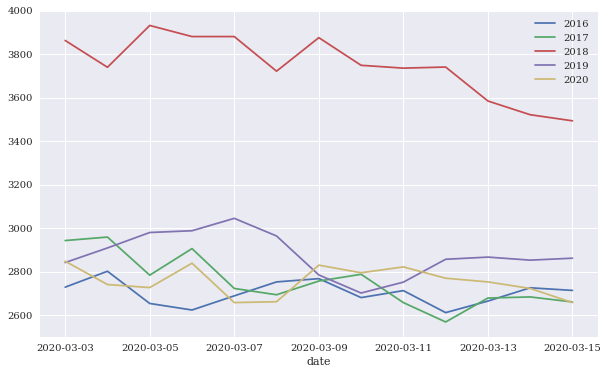

In [5]:
df_check = df[['date'] + ['{}'.format(yr) for yr in range(2016,2021)]].copy(deep=True)
df_check.index = df_check.date
del df_check['date']
df_check.plot(figsize=(10, 6))
plt.show()             

As can be seen from the above, 2018 was a massive outlier for daily deaths in 2018. This is correct, however. As the German Statistical office writes:

"*Bei den aktuell vorliegenden Daten sind die typischen Schwankungen während der Grippezeit von ungefähr Mitte Dezember bis Mitte April zu beachten. Dies wird deutlich, wenn man sich die Zahlen aus den Vorjahren anschaut: Im März 2019 starben beispielsweise etwa 86 000 Menschen, im März 2018, also in einem Jahr, als die Grippewelle besonders heftig ausfiel, waren es 107 000. Auch ohne Corona-Pandemie können die Sterbefallzahlen demnach in der typischen Grippezeit stark schwanken. Von diesen Schwankungen sind vorwiegend die Sterbefallzahlen in der Altersgruppe ab 65 Jahren betroffen.*"

Which means:

"*With the data currently available, the typical fluctuations during the flu season from about mid-December to mid-April should be noted. This becomes clear when looking at the figures from previous years: In March 2019, for example, around 86,000 people died, and in March 2018, i.e. in a year when the flu epidemic was particularly severe, the figure was 107,000. Even without a corona pandemic, the death figures can therefore fluctuate sharply during the typical flu season. These fluctuations mainly affect mortality rates in the 65+ age group.*"

In [6]:
pd.DataFrame(df_march.sum(axis=0), columns=['total deaths in March'])

,total deaths in March
2016,83669.0
2017,82934.0
2018,107104.0
2019,86419.0


In [7]:
107104 - (83669+82934+86419)/3

22763.33333333333

Computing cumulative sums

In [8]:
for yr in range(2016, 2021):
    df['cs_{}'.format(yr)] = df['{}'.format(yr)].cumsum()
    del df['{}'.format(yr)]

Computing daily growth rages for 2016-2019

In [9]:
for yr in range(2016, 2020):
    df['gr_{}'.format(yr)] = df['cs_{}'.format(yr)] / df['cs_{}'.format(yr)].shift(1)
    del df['cs_{}'.format(yr)]

Computing average daily growth rages 2016-2019

In [10]:
df['daily_growth'] = df.loc[:,['gr_{}'.format(yr) for yr in range(2016,2020)]].mean(axis=1)
df = df.drop(['gr_{}'.format(yr) for yr in range(2016,2020)], axis=1)

extrapolating forward

In [11]:
df['counterfactual'] = 0
df.loc[0,'counterfactual'] = df.loc[df.date=='2020-03-03','cs_2020'].values[0]

In [12]:
for i in range(1, df.shape[0]):
    df.loc[i,'counterfactual'] = df.loc[i-1,'counterfactual'] * df.loc[i,'daily_growth']

In [13]:
df = df.drop(['daily_growth'], axis=1)

# 2) Parsing Covid-19 deaths

In the metadata, we find the following:

"damit ergibt sich: Anzahl Todesfälle der aktuellen Publikation als Summe(AnzahlTodesfall) wenn NeuerTodesfall in (0,1)"

This means "therefore we have: number of deaths in the currently published data = sum(AnzahlTodesfall) if NeuerTodesfall in (0,1)".

In [14]:
official = pd.read_csv('./covid_deaths/RKI_COVID19.csv')
print(official.Datenstand.value_counts())
official = official[['AnzahlTodesfall', 'Meldedatum', 'NeuerTodesfall']]
official = official[(official.NeuerTodesfall == 0) | (official.NeuerTodesfall == 1)]
official['date'] = official.Meldedatum.astype('str').str[:10]
del official['Meldedatum']
del official['NeuerTodesfall']
official = official.groupby('date').sum().reset_index(drop=False).copy(deep=True)
official['covid_deaths'] = official.AnzahlTodesfall.cumsum()
del official['AnzahlTodesfall']

19.04.2020, 00:00 Uhr    105933
Name: Datenstand, dtype: int64


# 3) Merging and plotting

In [15]:
df = pd.merge(df, official, on=['date'], how='left')
df = df.fillna(0)
df['counterfactual_2020_covid'] = df.counterfactual + df.covid_deaths
del df['covid_deaths']
df.index = df.date
del df['date']

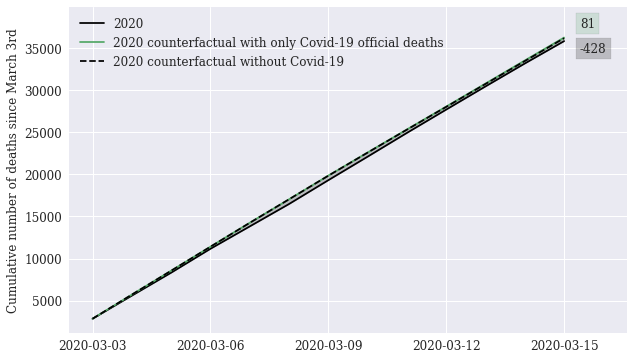

In [16]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df.index,
        df['cs_2020'],
        label='2020',
        color='black')
ax.plot(df.index,
        df['counterfactual_2020_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df.index,
        df['counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')

ax.set_xticks(df.index[[0,3,6,9,12]])
ax.fill_between(df.index, df['cs_2020'], df['counterfactual_2020_covid'], color='black', alpha='0.2')
ax.fill_between(df.index, df['counterfactual_2020_covid'], df['counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since March 3rd',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 1

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1 + 2000))

plt.text(12.4, 37500, '{}'.format(int(round(df.iloc[-1, 2] - df.iloc[-1, 1]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)


plt.text(12.4, 34500, '{}'.format(int(round(df.iloc[-1, 0] - df.iloc[-1, 2]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig('_germany.pdf', bbox_inches='tight', dpi=100)

In [17]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df.iloc[-1, 2] - df.iloc[-1, 1])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df.iloc[-1, 0] - df.iloc[-1, 1])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df.iloc[-1, 0] - df.iloc[-1, 2])))

Official covid-deaths: 81.0 = green - dashed black
Excess deaths: -347.0 = solid black - dashed black
Unexplained excess deaths: -428.0 = solid black - green
